**AUTHOR:** <br>
Vasilis Raptis

**DATE:** <br>
20.05.2024 

**PURPOSE:** <br>
This notebook: 
- downloads the phenotypic data for the delirium GWAS, queried during the dataset creation. 
- downloads precomputed ancestry PCs and predicted ancestry for individuals with srWGS data.
- merges and does some basic cleaning on the phenotype and covariates.
- make "age" variable as (age_at_first_delirium_episode OR age_at_cencoring) - dob
- extact full table of phenotype and covariates into gooogle bucket

**NOTE:** <br>
- This notebook needs to be run once, as it saves the phenotype/covariates file to the bucket. After this, just load the *"{my_bucket}/data/full_pheno_df.csv"* file into the workspace.
- **UPDATE 03.06.2024:** an updated pheno file has been created: *"{my_bucket}/data/full_pheno_clean_del_df.csv"* . This use uses only the F05 and X293.0 delirium codes, for consistency with other cohorts. Not much changes, ~100 cases less.
- **UPDATE 03.06.2024:** output age as integer. DOB is censored to "06-15" mm-dd, so there is no point for finer age definition.

**Setup:**

In [1]:
## libraries
library(tidyverse)
library(bigrquery)
library(data.table)

## Get my bucket name
my_bucket  <- Sys.getenv("WORKSPACE_BUCKET")
my_bucket
## Google project name
GOOGLE_PROJECT <- Sys.getenv("GOOGLE_PROJECT")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




[1] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f"

In [2]:
# List data in my bucket
system(paste0("gsutil ls ", my_bucket, "/data"), intern=T)
# List object in workspace
system("ls .", intern=T)

[1] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/arrays/" 
[2] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/"  
[3] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/regenie/"

[1] "00_run_notebook_in_background.ipynb"                   
 [2] "00_test_notebook.ipynb"                                
 [3] "01_part1_pheno_preprocessing.ipynb"                    
 [4] "01_part2_pheno_by_ancestry.ipynb"                      
 [5] "01_part3_age_match_subsample.ipynb"                    
 [6] "02_part1_genotypes_preprocessing_20240516_215713.ipynb"
 [7] "02_part1_genotypes_preprocessing_20240520_162841.ipynb"
 [8] "02_part1_genotypes_preprocessing.ipynb"                
 [9] "03_part1b_run_regenie_step1_afr_20240522_123557.ipynb" 
[10] "03_part1b_run_regenie_step1_eur_20240523_130707.ipynb" 
[11] "03_part1b_run_regenie_step1_eur_20240524_082548.ipynb" 
[12] "03_part1b_run_regenie_step1_eur.ipynb"                 
[13] "03_part1_run_regenie_step1.ipynb"                      
[14] "03_part2b_run_regenie_step2_clinvar.ipynb"             
[15] "03_part2_run_regenie_step2_20240523_085900.ipynb"      
[16] "03_part2_run_regenie_step2_20240526_163148.ipynb"      
[17] "03_part2_run_regenie_step2.ipynb"                      
[18] "04_part1_gwas_plots.ipynb"                             
[19] "05_part1_meta_analysis.ipynb"                          
[20] "06_part1_replication.ipynb"                            
[21] "ancestry_preds.tsv"                                    
[22] "full_pheno_clean_del_df.csv"                           
[23] "x01.1_process_delirium&dementia_pheno.ipynb"

**Queries:** 

**the code below was copied when the dataset "delirium gwas -basics" was created*

In [2]:
#This query represents dataset "delirium gwas  - basic" for domain "person" and was generated for All of Us Controlled Tier Dataset v7
dataset_17536089_person_sql <- paste("
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `person` person 
    LEFT JOIN
        `concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
person_17536089_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "person_17536089",
  "person_17536089_*.csv")
message(str_glue('The data will be written to {person_17536089_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_17536089_person_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  person_17536089_path,
  destination_format = "CSV")



The data will be written to gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/bq_exports/vraptis@researchallofus.org/20241022/person_17536089/person_17536089_*.csv. Use this path when reading the data into your notebooks in the future.



In [3]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {person_17536089_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(gender = col_character(), race = col_character(), ethnicity = col_character(), sex_at_birth = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
dataset_17536089_person_df <- read_bq_export_from_workspace_bucket(person_17536089_path)

dim(dataset_17536089_person_df)

head(dataset_17536089_person_df, 5)

Loading gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/bq_exports/vraptis@researchallofus.org/20241022/person_17536089/person_17536089_000000000000.csv.



[1] 413457     10

person_id,gender_concept_id,gender,date_of_birth,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,sex_at_birth
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
1118161,1585843,Gender Identity: Additional Options,1964-06-15 00:00:00 UTC,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
1620611,1585843,Gender Identity: Additional Options,1983-06-15 00:00:00 UTC,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
2474732,1585843,Gender Identity: Additional Options,1987-06-15 00:00:00 UTC,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
2449537,2000000002,"Not man only, not woman only, prefer not to answer, or skipped",1989-06-15 00:00:00 UTC,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer
2673939,2000000002,"Not man only, not woman only, prefer not to answer, or skipped",1990-06-15 00:00:00 UTC,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,1177221,I prefer not to answer


In [5]:
# This query represents dataset "delirium gwas  - basic" for domain "condition" and was generated for All of Us Controlled Tier Dataset v7
dataset_17536089_condition_sql <- paste("
    SELECT
        c_occurrence.person_id,
        c_occurrence.condition_concept_id,
        c_standard_concept.concept_name as standard_concept_name,
        c_standard_concept.concept_code as standard_concept_code,
        c_standard_concept.vocabulary_id as standard_vocabulary,
        c_occurrence.condition_start_datetime,
        c_occurrence.condition_end_datetime,
        c_occurrence.condition_type_concept_id,
        c_type.concept_name as condition_type_concept_name,
        c_occurrence.stop_reason,
        c_occurrence.visit_occurrence_id,
        visit.concept_name as visit_occurrence_concept_name,
        c_occurrence.condition_source_value,
        c_occurrence.condition_source_concept_id,
        c_source_concept.concept_name as source_concept_name,
        c_source_concept.concept_code as source_concept_code,
        c_source_concept.vocabulary_id as source_vocabulary,
        c_occurrence.condition_status_source_value,
        c_occurrence.condition_status_concept_id,
        c_status.concept_name as condition_status_concept_name 
    FROM
        ( SELECT
            * 
        FROM
            `condition_occurrence` c_occurrence 
        WHERE
            (
                condition_concept_id IN (SELECT
                    DISTINCT c.concept_id 
                FROM
                    `cb_criteria` c 
                JOIN
                    (SELECT
                        CAST(cr.id as string) AS id       
                    FROM
                        `cb_criteria` cr       
                    WHERE
                        concept_id IN (373995, 379779)       
                        AND full_text LIKE '%_rank1]%'      ) a 
                        ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                        OR c.path LIKE CONCAT('%.', a.id) 
                        OR c.path LIKE CONCAT(a.id, '.%') 
                        OR c.path = a.id) 
                WHERE
                    is_standard = 1 
                    AND is_selectable = 1) 
                OR  condition_source_concept_id IN (SELECT
                    DISTINCT c.concept_id 
                FROM
                    `cb_criteria` c 
                JOIN
                    (SELECT
                        CAST(cr.id as string) AS id       
                    FROM
                        `cb_criteria` cr       
                    WHERE
                        concept_id IN (35207116, 44826487, 44826488, 44833398, 45552431)       
                        AND full_text LIKE '%_rank1]%'      ) a 
                        ON (c.path LIKE CONCAT('%.', a.id, '.%') 
                        OR c.path LIKE CONCAT('%.', a.id) 
                        OR c.path LIKE CONCAT(a.id, '.%') 
                        OR c.path = a.id) 
                WHERE
                    is_standard = 0 
                    AND is_selectable = 1)
            )) c_occurrence 
    LEFT JOIN
        `concept` c_standard_concept 
            ON c_occurrence.condition_concept_id = c_standard_concept.concept_id 
    LEFT JOIN
        `concept` c_type 
            ON c_occurrence.condition_type_concept_id = c_type.concept_id 
    LEFT JOIN
        `visit_occurrence` v 
            ON c_occurrence.visit_occurrence_id = v.visit_occurrence_id 
    LEFT JOIN
        `concept` visit 
            ON v.visit_concept_id = visit.concept_id 
    LEFT JOIN
        `concept` c_source_concept 
            ON c_occurrence.condition_source_concept_id = c_source_concept.concept_id 
    LEFT JOIN
        `concept` c_status 
            ON c_occurrence.condition_status_concept_id = c_status.concept_id", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
condition_17536089_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "condition_17536089",
  "condition_17536089_*.csv")
message(str_glue('The data will be written to {condition_17536089_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_17536089_condition_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  condition_17536089_path,
  destination_format = "CSV")



The data will be written to gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/bq_exports/vraptis@researchallofus.org/20240603/condition_17536089/condition_17536089_*.csv. Use this path when reading the data into your notebooks in the future.



In [6]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {condition_17536089_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- cols(standard_concept_name = col_character(), standard_concept_code = col_character(), standard_vocabulary = col_character(), condition_type_concept_name = col_character(), stop_reason = col_character(), visit_occurrence_concept_name = col_character(), condition_source_value = col_character(), source_concept_name = col_character(), source_concept_code = col_character(), source_vocabulary = col_character(), condition_status_source_value = col_character(), condition_status_concept_name = col_character())
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
dataset_17536089_condition_df <- read_bq_export_from_workspace_bucket(condition_17536089_path)

dim(dataset_17536089_condition_df)

head(dataset_17536089_condition_df, 5)

Loading gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/bq_exports/vraptis@researchallofus.org/20240603/condition_17536089/condition_17536089_000000000000.csv.



[1] 8785   20

person_id,condition_concept_id,standard_concept_name,standard_concept_code,standard_vocabulary,condition_start_datetime,condition_end_datetime,condition_type_concept_id,condition_type_concept_name,stop_reason,visit_occurrence_id,visit_occurrence_concept_name,condition_source_value,condition_source_concept_id,source_concept_name,source_concept_code,source_vocabulary,condition_status_source_value,condition_status_concept_id,condition_status_concept_name
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
2172933,377830,Alcohol withdrawal delirium,8635005,SNOMED,2022-04-21 00:00:00 UTC,NA,44786629,Secondary Condition,NA,4.4e+16,Outpatient Visit,8635005,377830,Alcohol withdrawal delirium,8635005,SNOMED,NA,NA,NA
1391448,373995,Delirium,2776000,SNOMED,2020-01-15 05:00:00 UTC,NA,32821,EHR billing record,NA,NA,NA,F05,35207116,Delirium due to known physiological condition,F05,ICD10CM,NA,NA,NA
1103897,373995,Delirium,2776000,SNOMED,2018-05-21 00:00:00 UTC,2018-05-21 11:59:59 UTC,44786627,Primary Condition,NA,2.7e+16,Inpatient Visit,F05,35207116,Delirium due to known physiological condition,F05,ICD10CM,NA,NA,NA
7817548,373995,Delirium,2776000,SNOMED,2020-10-23 00:00:00 UTC,2020-10-23 11:59:59 UTC,44786629,Secondary Condition,NA,2.7e+16,Inpatient Visit,F05,35207116,Delirium due to known physiological condition,F05,ICD10CM,NA,NA,NA
1771334,373995,Delirium,2776000,SNOMED,2022-03-15 00:00:00 UTC,2022-03-15 11:59:59 UTC,44786629,Secondary Condition,NA,2.7e+16,Inpatient Visit,F05,35207116,Delirium due to known physiological condition,F05,ICD10CM,NA,NA,NA


In [7]:
# This query represents dataset "delirium gwas  - basic" for domain "zip_code_socioeconomic" and was generated for All of Us Controlled Tier Dataset v7
dataset_17536089_zip_code_socioeconomic_sql <- paste("
    SELECT
        observation.person_id,
        observation.observation_datetime,
        zip_code.deprivation_index 
    FROM
        `zip3_ses_map` zip_code 
    JOIN
        `observation` observation 
            ON CAST(SUBSTR(observation.value_as_string, 0, STRPOS(observation.value_as_string, '*') - 1) AS INT64) = zip_code.zip3 
            AND observation_source_concept_id = 1585250 
            AND observation.value_as_string NOT LIKE 'Res%'", sep="")

# Formulate a Cloud Storage destination path for the data exported from BigQuery.
# NOTE: By default data exported multiple times on the same day will overwrite older copies.
#       But data exported on a different days will write to a new location so that historical
#       copies can be kept as the dataset definition is changed.
zip_code_socioeconomic_17536089_path <- file.path(
  Sys.getenv("WORKSPACE_BUCKET"),
  "bq_exports",
  Sys.getenv("OWNER_EMAIL"),
  strftime(lubridate::now(), "%Y%m%d"),  # Comment out this line if you want the export to always overwrite.
  "zip_code_socioeconomic_17536089",
  "zip_code_socioeconomic_17536089_*.csv")
message(str_glue('The data will be written to {zip_code_socioeconomic_17536089_path}. Use this path when reading ',
                 'the data into your notebooks in the future.'))

# Perform the query and export the dataset to Cloud Storage as CSV files.
# NOTE: You only need to run `bq_table_save` once. After that, you can
#       just read data from the CSVs in Cloud Storage.
bq_table_save(
  bq_dataset_query(Sys.getenv("WORKSPACE_CDR"), dataset_17536089_zip_code_socioeconomic_sql, billing = Sys.getenv("GOOGLE_PROJECT")),
  zip_code_socioeconomic_17536089_path,
  destination_format = "CSV")



The data will be written to gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/bq_exports/vraptis@researchallofus.org/20240603/zip_code_socioeconomic_17536089/zip_code_socioeconomic_17536089_*.csv. Use this path when reading the data into your notebooks in the future.



In [8]:
# Read the data directly from Cloud Storage into memory.
# NOTE: Alternatively you can `gsutil -m cp {zip_code_socioeconomic_17536089_path}` to copy these files
#       to the Jupyter disk.
read_bq_export_from_workspace_bucket <- function(export_path) {
  col_types <- NULL
  bind_rows(
    map(system2('gsutil', args = c('ls', export_path), stdout = TRUE, stderr = TRUE),
        function(csv) {
          message(str_glue('Loading {csv}.'))
          chunk <- read_csv(pipe(str_glue('gsutil cat {csv}')), col_types = col_types, show_col_types = FALSE)
          if (is.null(col_types)) {
            col_types <- spec(chunk)
          }
          chunk
        }))
}
dataset_17536089_zip_code_socioeconomic_df <- read_bq_export_from_workspace_bucket(zip_code_socioeconomic_17536089_path)

dim(dataset_17536089_zip_code_socioeconomic_df)

head(dataset_17536089_zip_code_socioeconomic_df, 5)

Loading gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/bq_exports/vraptis@researchallofus.org/20240603/zip_code_socioeconomic_17536089/zip_code_socioeconomic_17536089_000000000000.csv.



[1] 413174      3

person_id,observation_datetime,deprivation_index
<dbl>,<chr>,<dbl>
6742524,2021-01-17 00:08:48 UTC,0.2852150
1561591,2019-05-01 21:30:34 UTC,0.2852150
1973304,2019-09-18 17:04:31 UTC,0.2630131
5451725,2022-06-18 03:17:43 UTC,0.2630131
1032596,2019-10-09 22:23:57 UTC,0.3551754


**Process delirium phenotypes:**

In [9]:
## summary of instances per delirium type 
dataset_17536089_condition_df %>% 
    mutate(source_concept_name_code = paste0(source_concept_name, "_", source_concept_code)) %>%      
    group_by(source_concept_name_code) %>% summarise(n=n()) %>% arrange(desc(n)) %>%
    head(.,10)


source_concept_name_code,n
<chr>,<int>
Alcohol dependence with withdrawal delirium_F10.231,3298
Delirium due to known physiological condition_F05,2957
Delirium due to conditions classified elsewhere_293.0,982
Alcohol withdrawal delirium_291.0,683
Delirium_2776000,230
Drug-induced delirium_292.81,221
"Other psychoactive substance use, unspecified with intoxication with delirium_F19.921",66
Alcohol withdrawal delirium_8635005,56
Subacute delirium_293.1,51


# of delirium instances: 3939 
# of unique delirium indivuals: 1889

person_id,delirium_code,delirium_date,delirium_count
<dbl>,<chr>,<dttm>,<int>
1000320,F05,2017-07-27,1
1001121,F05,2020-05-15,3
1002832,F05,2019-11-19,1
1002867,F05,2017-03-19,1
1003498,F05,2016-02-10,1
1004234,F05,2020-11-19,1


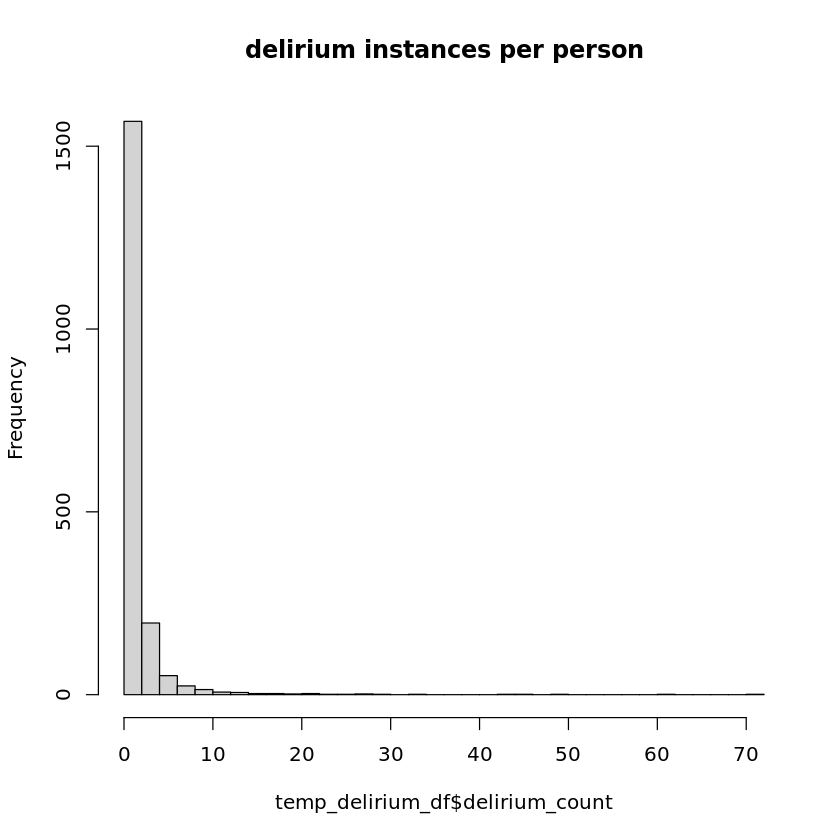

In [10]:
### filter and reformat delirium phenotypes
#delirium_concept_codes <- c("F05", "293.0", "2776000")
delirium_concept_codes <- c("F05", "293.0")

temp_delirium_df <-
dataset_17536089_condition_df %>% 
    ## extract cases for delirium not induced by alcohol/other substances
    filter(source_concept_code %in% delirium_concept_codes) %>%
    ## reformat starting date variable
    mutate(delirium_date = strptime(condition_start_datetime, format="%Y-%m-%d")) %>% 
    ## select relevant columns: id, delirium_code, delirium_date
    select(person_id, source_concept_code, delirium_date) %>%
    ## extract only the first delirium instance per person
    group_by(person_id) %>%
    mutate(delirium_count = n()) %>% # calculate number of delirium instances per person
    arrange(delirium_date) %>% 
    slice(1L) %>% 
    ## rename columns
    rename(delirium_code = source_concept_code)

cat("# of delirium instances:", sum(temp_delirium_df$delirium_count), "\n")
cat("# of unique delirium indivuals:", nrow(temp_delirium_df))

temp_delirium_df %>% head

### delirium instances per person
hist(temp_delirium_df$delirium_count, breaks=50, main="delirium instances per person")


**Process basic demographics:**

In [11]:
## summary of demographic variables
dataset_17536089_person_df %>% group_by(race) %>% summarise(n=n()) %>% arrange(desc(n))
dataset_17536089_person_df %>% group_by(ethnicity) %>% summarise(n=n()) %>% arrange(desc(n))
dataset_17536089_person_df %>% group_by(sex_at_birth) %>% summarise(n=n()) %>% arrange(desc(n))


race,n
<chr>,<int>
White,229158
Black or African American,78504
None Indicated,64769
Asian,14215
PMI: Skip,9142
More than one population,7742
None of these,4379
I prefer not to answer,2550
Middle Eastern or North African,2513


ethnicity,n
<chr>,<int>
Not Hispanic or Latino,323175
Hispanic or Latino,74114
PMI: Skip,9142
What Race Ethnicity: Race Ethnicity None Of These,4379
PMI: Prefer Not To Answer,2550
No matching concept,97


sex_at_birth,n
<chr>,<int>
Female,249565
Male,155169
No matching concept,4284
PMI: Skip,3855
I prefer not to answer,346
None,146
Intersex,92


In [12]:
### filter and reformat basic demographics
temp_person_df <-
dataset_17536089_person_df %>% 
    ## select relevant columns
    select(person_id, date_of_birth, sex_at_birth, race) %>%
    ## reformat dob as date
    mutate(date_of_birth = strptime(date_of_birth, format="%Y-%m-%d")) %>% 
    ## reformat sex_at_birth: 0 female; 1 male; NA other  
    mutate(sex_at_birth = case_when(sex_at_birth=="Female" ~ 0,
                           sex_at_birth=="Male" ~ 1,
                           TRUE ~ NA)) %>%
    ## rename columns
    rename(dob = date_of_birth,
           sex = sex_at_birth)
temp_person_df %>% head

cat("# of people by sex (0=female; 1=male; NA: other):")
temp_person_df$sex %>% as.factor %>% summary

person_id,dob,sex,race
<dbl>,<dttm>,<dbl>,<chr>
1116891,1946-06-15,NA,None Indicated
5134042,1939-06-15,NA,None Indicated
2793265,1959-06-15,NA,None Indicated
8695617,1977-06-15,NA,None Indicated
2002132,1943-06-15,NA,None Indicated
5054422,1984-06-15,NA,None Indicated


# of people by sex (0=female; 1=male; NA: other):

0      1   NA's 
249565 155169   8723

In [13]:
## summary of dob
##!! some dobs in 190* - error?? - keep for now
temp_person_df %>% arrange(dob) %>% summary

   person_id            dob                                sex       
 Min.   :1000000   Min.   :1900-06-15 00:00:00.0000   Min.   :0.000  
 1st Qu.:1563091   1st Qu.:1955-06-15 00:00:00.0000   1st Qu.:0.000  
 Median :2157907   Median :1967-06-15 00:00:00.0000   Median :0.000  
 Mean   :2875706   Mean   :1968-08-13 07:38:47.3743   Mean   :0.383  
 3rd Qu.:3200517   3rd Qu.:1983-06-15 00:00:00.0000   3rd Qu.:1.000  
 Max.   :9999697   Max.   :2004-06-15 00:00:00.0000   Max.   :1.000  
                                                      NA's   :8723   
     race          
 Length:413457     
 Class :character  
 Mode  :character  
                   
                   
                   
                   

**Process deprivation index:**

In [14]:
temp_depriv_df <-
dataset_17536089_zip_code_socioeconomic_df %>%    
    ## reformat date
    mutate(depind_date = strptime(observation_datetime, "%Y-%m-%d")) %>% 
    select(person_id, deprivation_index, depind_date) %>%
    rename(depind = deprivation_index)
head(temp_depriv_df)

person_id,depind,depind_date
<dbl>,<dbl>,<dttm>
6742524,0.2852150,2021-01-17
1561591,0.2852150,2019-05-01
1973304,0.2630131,2019-09-18
5451725,0.2630131,2022-06-18
1032596,0.3551754,2019-10-09
1101259,0.3551754,2019-06-25


**Load precomputed predicted ancestry & genomic PCs file:**

*see: https://support.researchallofus.org/hc/en-us/articles/4614687617556-How-the-All-of-Us-Genomic-data-are-organized ; section "srWGS genetic predicted ancestry"*

In [15]:
## locate srWGS ancestry files 
system(paste("gsutil -u", GOOGLE_PROJECT, "ls gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry"), intern=T)
## Copy ancestry_preds.tsv table to workspace
system(paste("gsutil -u", GOOGLE_PROJECT, "cp gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry/ancestry_preds.tsv ."), intern=T)
## Check that the file is in workspace
system("ls ", intern=T)
## load ancestry table
ancestry_pred <- fread("ancestry_preds.tsv")

[1] "gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry/ancestry_preds.tsv"                        
[2] "gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry/merged_sites_only_intersection.vcf.bgz"    
[3] "gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry/merged_sites_only_intersection.vcf.bgz.tbi"
[4] "gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry/preds_oth.html"                            
[5] "gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry/loadings.ht/"

character(0)

[1] "00_run_notebook_in_background.ipynb"                   
 [2] "00_test_notebook.ipynb"                                
 [3] "01_part1_pheno_preprocessing.ipynb"                    
 [4] "01_part2_pheno_by_ancestry.ipynb"                      
 [5] "01_part3_age_match_subsample.ipynb"                    
 [6] "02_part1_genotypes_preprocessing_20240516_215713.ipynb"
 [7] "02_part1_genotypes_preprocessing_20240520_162841.ipynb"
 [8] "02_part1_genotypes_preprocessing.ipynb"                
 [9] "03_part1b_run_regenie_step1_afr_20240522_123557.ipynb" 
[10] "03_part1b_run_regenie_step1_eur_20240523_130707.ipynb" 
[11] "03_part1b_run_regenie_step1_eur_20240524_082548.ipynb" 
[12] "03_part1b_run_regenie_step1_eur.ipynb"                 
[13] "03_part1_run_regenie_step1.ipynb"                      
[14] "03_part2b_run_regenie_step2_clinvar.ipynb"             
[15] "03_part2_run_regenie_step2_20240523_085900.ipynb"      
[16] "03_part2_run_regenie_step2_20240526_163148.ipynb"      
[17] "03_part2_run_regenie_step2.ipynb"                      
[18] "04_part1_gwas_plots.ipynb"                             
[19] "05_part1_meta_analysis.ipynb"                          
[20] "06_part1_replication.ipynb"                            
[21] "ancestry_preds.tsv"                                    
[22] "full_pheno_clean_del_df.csv"                           
[23] "x01.1_process_delirium&dementia_pheno.ipynb"

In [16]:
PCs <- paste0("PC", seq(1:16))

temp_ancestry_pred_df <-
ancestry_pred %>% 
    ## split and format PC loadings 
    separate_wider_delim(cols = pca_features, delim = ",", names = PCs) %>%
    mutate(PC1 = str_remove(PC1, "\\[")) %>%  
    mutate(PC16 = str_remove(PC16, "\\]")) %>%
    mutate(across(all_of(PCs), as.numeric)) %>% 
    ## rename columns
    rename(person_id = research_id, gen_ancestry = ancestry_pred_other) %>%
    ## select relevant variables
    select(person_id, gen_ancestry, all_of(PCs))

**Merge into one df:**

In [17]:
temp_merged_pheno_df <-
inner_join(temp_person_df, temp_depriv_df, by="person_id") %>% 
    left_join(., temp_ancestry_pred_df, by="person_id") %>%
    left_join(., temp_delirium_df, by="person_id")
dim(temp_merged_pheno_df)
temp_merged_pheno_df %>% head

[1] 413174     26

person_id,dob,sex,race,depind,depind_date,gen_ancestry,PC1,PC2,PC3,⋯,PC10,PC11,PC12,PC13,PC14,PC15,PC16,delirium_code,delirium_date,delirium_count
<dbl>,<dttm>,<dbl>,<chr>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<int>
1116891,1946-06-15,NA,None Indicated,0.3512714,2021-08-23,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5134042,1939-06-15,NA,None Indicated,0.2725629,2021-08-23,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2793265,1959-06-15,NA,None Indicated,0.4313811,2018-05-08,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8695617,1977-06-15,NA,None Indicated,0.1921735,2021-12-07,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2002132,1943-06-15,NA,None Indicated,0.3166138,2021-12-27,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5054422,1984-06-15,NA,None Indicated,0.2693429,2021-08-08,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


**Make age variable:**

Define age as:
- age at first reported delirium for **delirium cases**: delirium_date - dob
- age at censoring for **delirium controls**: censoring_date - dob

*censoring date for CDR v7 is **July 1, 2022**, see: https://support.researchallofus.org/hc/en-us/articles/360051661772-What-are-the-CDR-cutoff-dates

In [18]:
# note: I couldn't find death date, add age at death for applicable controls if available. Leave it for now
censoring_date <- strptime("2022-07-01", format="%Y-%m-%d")

full_pheno_df <-
temp_merged_pheno_df %>%
    ## make delirium status variable: 0=control; 1=case
    mutate(delirium_status = ifelse(!is.na(delirium_code),1,0)) %>% 
    ## make age variable
    mutate(age = case_when(!is.na(delirium_code) ~ round(as.numeric(difftime(delirium_date, dob, units = "days")/365.25),2), 
                           TRUE ~ round(as.numeric(difftime(censoring_date, dob, units = "days")/365.25),2))) %>%
    ## round age to closest integer
    mutate(age = as.integer(age))
full_pheno_df %>% head

person_id,dob,sex,race,depind,depind_date,gen_ancestry,PC1,PC2,PC3,⋯,PC12,PC13,PC14,PC15,PC16,delirium_code,delirium_date,delirium_count,delirium_status,age
<dbl>,<dttm>,<dbl>,<chr>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<int>,<dbl>,<int>
1116891,1946-06-15,NA,None Indicated,0.3512714,2021-08-23,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,76
5134042,1939-06-15,NA,None Indicated,0.2725629,2021-08-23,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,83
2793265,1959-06-15,NA,None Indicated,0.4313811,2018-05-08,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,63
8695617,1977-06-15,NA,None Indicated,0.1921735,2021-12-07,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,45
2002132,1943-06-15,NA,None Indicated,0.3166138,2021-12-27,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,79
5054422,1984-06-15,NA,None Indicated,0.2693429,2021-08-08,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,38


**Save final phenotype file to bucket:**

In [19]:
# This snippet assumes that you run setup first

# This code saves your dataframe into a csv file in a "data" folder in Google Bucket

# Replace df with THE NAME OF YOUR DATAFRAME
my_dataframe <- full_pheno_df

# Replace 'test.csv' with THE NAME of the file you're going to store in the bucket (don't delete the quotation marks)
destination_filename <- 'full_pheno_clean_del_df.csv'

########################################################################
##
################# DON'T CHANGE FROM HERE ###############################
##
########################################################################

# store the dataframe in current workspace
write_excel_csv(my_dataframe, destination_filename)

# Get the bucket name
my_bucket <- Sys.getenv('WORKSPACE_BUCKET')

# Copy the file from current workspace to the bucket
system(paste0("gsutil cp ./", destination_filename, " ", my_bucket, "/data/pheno/"), intern=T)

# Check if file is in the bucket
system(paste0("gsutil ls ", my_bucket, "/data/pheno/*.csv"), intern=T)


character(0)

[1] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/full_pheno_clean_del_df.csv"
[2] "gs://fc-secure-0e4de6e0-e2d7-4267-949d-7b1ad758a53f/data/pheno/full_pheno_df.csv"